Copyright 2015-2025 Universidad Complutense de Madrid (UCM)

This file contains code adapted from Numina https://github.com/guaix-ucm/numina.

It was developed by N. Cardiel for students of the Astrophysics Master (UCM).

This is an adapted version for lectures at ULS (Chile).

* License:
SPDX-License-Identifier: GPL-3.0+

* Modified by:
C. Cabello (UCM; Spain), 
L. Costantin (CAB; Spain)

## Spectrum straightening

Spectroscopic images present distortions not only in the spectral direction (which we have already corrected with the wavelength calibration) but also in the spatial direction. To correct for this second effect we should have traces of relatively bright spectra, corresponding to point sources, distributed along the slit. Since we do not have this, we will perform a first-order correction by fitting a low-degree polynomial to the brightest part of each two-dimensional spectrum, and straightening the image so that the pixels corresponding to this polynomial are arranged perfectly horizontally.

### Imports

In [1]:
'''
:Settings:
conda activate uls_2025

:History:
23 Mar 25:  version 1.0
'''

import numpy as np
import teareduce as tea
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path
from astropy.io import fits
from tqdm.notebook import tqdm
from astropy.table import QTable

tea.avoid_astropy_warnings(True)

__version__ = "1.0"
__author__  = "Cristina Cabello (UCM, Spain) and Luca Costantin (CAB, Spain)"


### Read files

In [2]:
galaxy_ID        = 'NGC2366'
specphot_star_ID = 'HR3454'

## MODIFY THE FOLLOWING

abs_path = f'/home/diegosuzaku/NGC2366Workshop'

dir_calibration = Path(f'{abs_path}/calibration/spectroscopy')


### Galaxy

We load the array of the 2D spectroscopic image of the galaxy

In [3]:
input_filename = dir_calibration / f'combined_{galaxy_ID}_skysub.fits'
data   = fits.getdata(input_filename)
header = fits.getheader(input_filename)

naxis2, naxis1 = data.shape
print(f'NAXIS1={naxis1}')
print(f'NAXIS2={naxis2}')

NAXIS1=2039
NAXIS2=1191


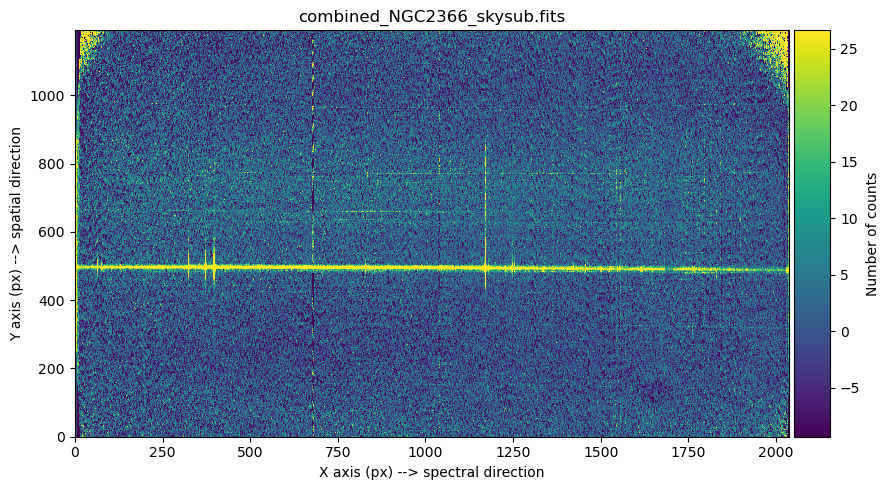

In [4]:
vmin, vmax = np.percentile(data, [5, 99])

fig, ax = plt.subplots(figsize=(9, 5))
tea.imshow(fig, ax, data, vmin=vmin, vmax=vmax,
           title=f"{str(input_filename).split('/')[-1]}",
           cmap='viridis', aspect='auto')

ax.set_xlabel('X axis (px) --> spectral direction')
ax.set_ylabel('Y axis (px) --> spatial direction')
plt.tight_layout()


We identify the rectangle (array indices) in which the spectrum we want to straighten is located. To reduce noise we will use a median filter of 51 pixels in the spectral direction and 1 pixel in the spatial direction (i.e. `median_size=(1, 51)`; we will not average on the Y-axis).

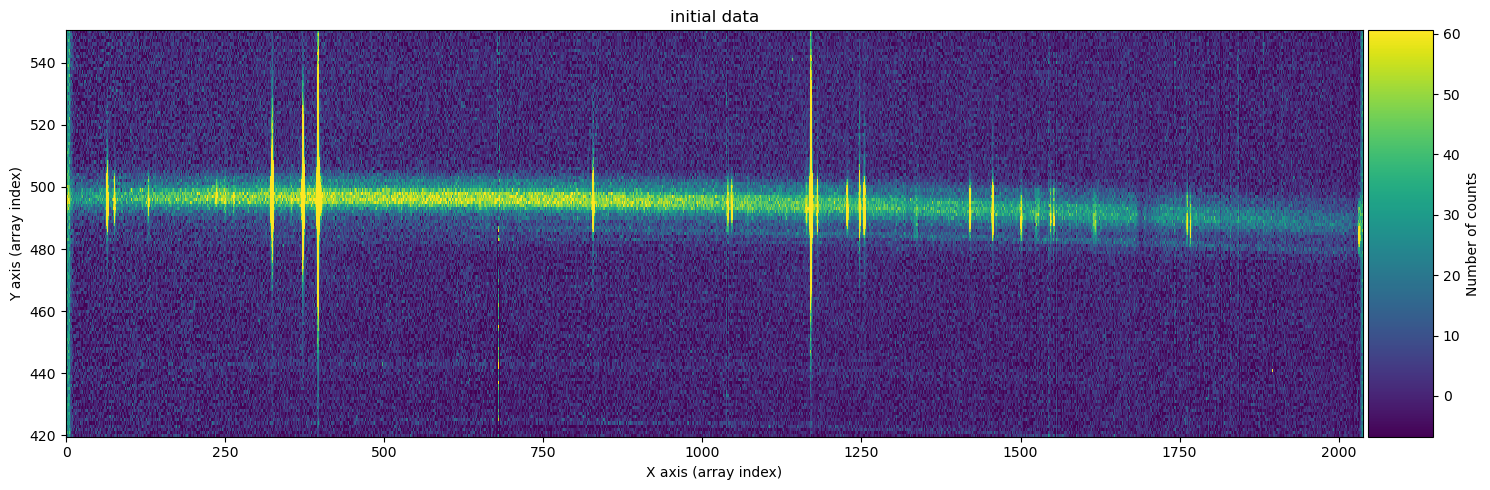

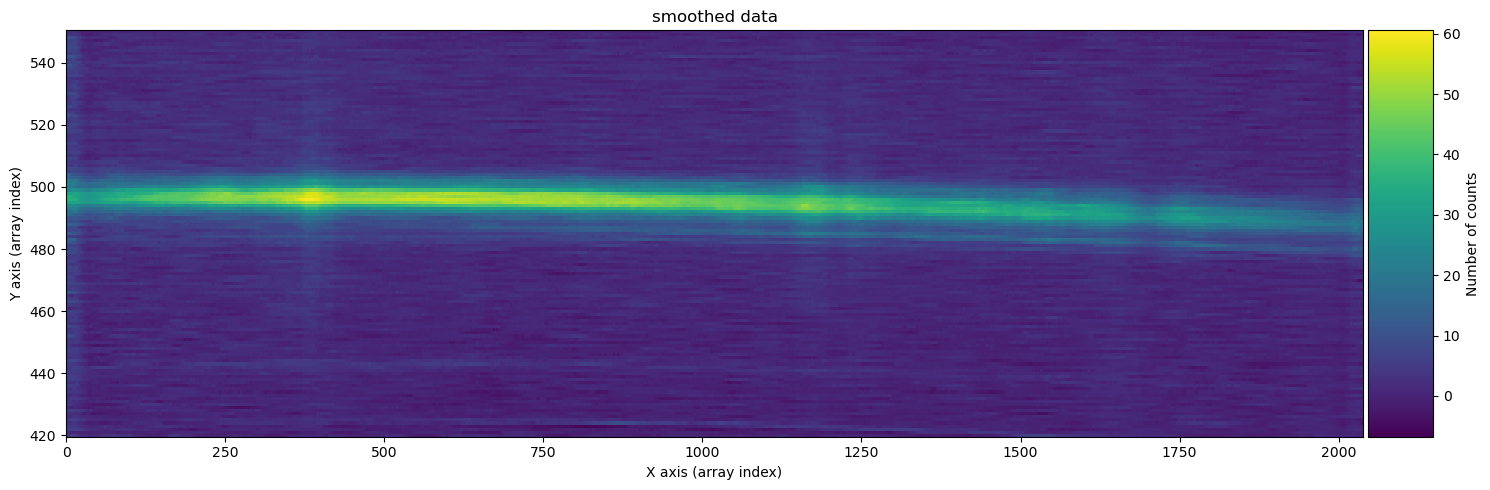

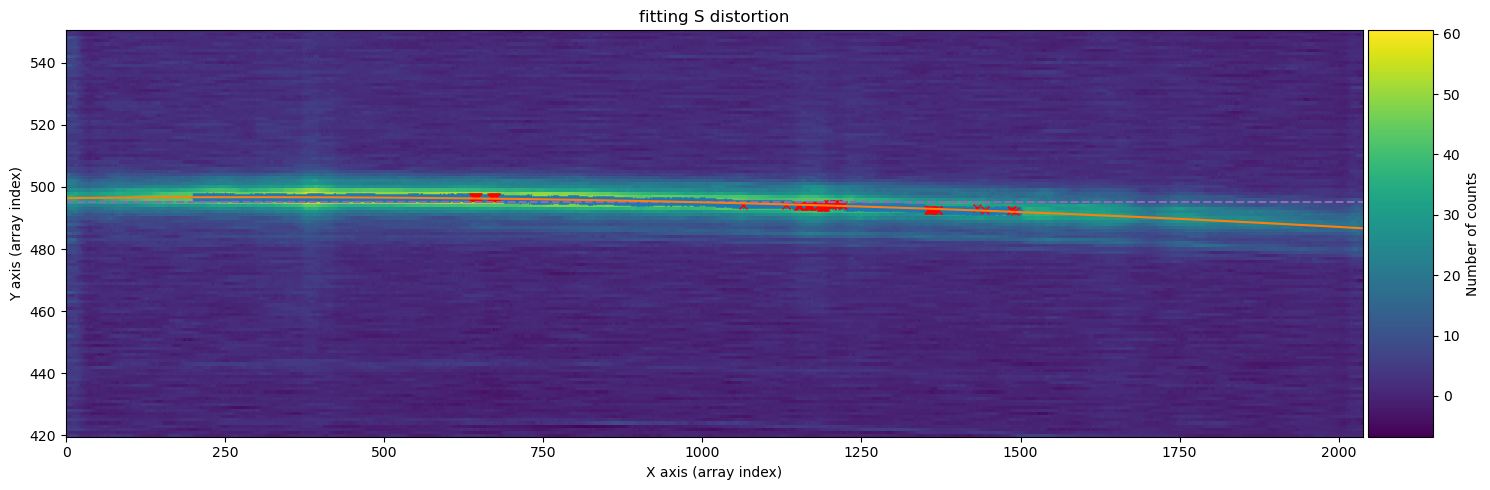

  0%|          | 0/2039 [00:00<?, ?it/s]

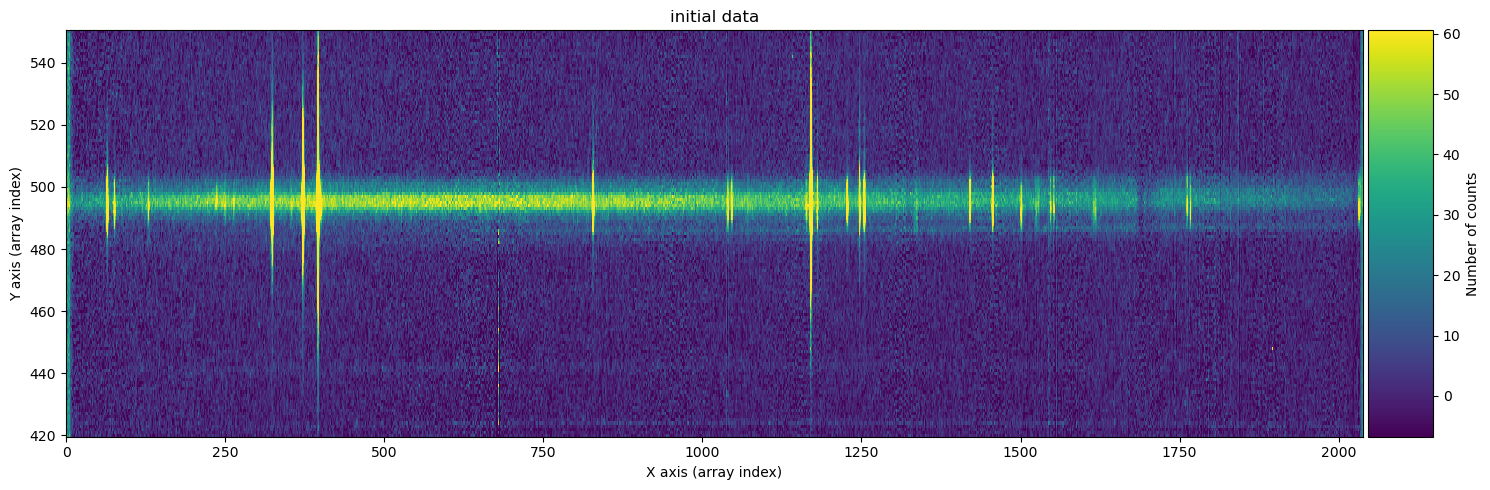

In [5]:
data_straight, poly_funct_peaks = tea.fit_sdistortion(data=data,
                                                      ns_min=420,
                                                      ns_max=550,
                                                      nc_min=200,
                                                      nc_max=1500,
                                                      median_size=(1, 51),
                                                      cmap='viridis')

In [6]:
hdu = fits.PrimaryHDU(data=data_straight, header=header)
output_filename = Path(input_filename.parent) / f'{input_filename.stem}_straight.fits'

hdu.writeto(output_filename, overwrite=True)

#### Extraction of the 1D spectrum

In [7]:
input_filename = output_filename
data   = fits.getdata(dir_calibration / input_filename)
header = fits.getheader(dir_calibration / input_filename)

In [8]:
cunit1 = 1 * u.Unit(header['cunit1'])
crpix1 = header['crpix1'] * u.pixel
crval1 = header['crval1'] * u.Unit(cunit1)
cdelt1 = header['cdelt1'] * u.Unit(cunit1) / u.pixel
ctype1 = header['ctype1']
print(f'crpix1: {crpix1}')
print(f'crval1: {crval1}')
print(f'cdelt1: {cdelt1}')
print(f'cunit1: {cunit1}')
print(f'ctype1: {ctype1}')

wavelength = crval1 + ((np.arange(naxis1) + 1)*u.pixel - crpix1) * cdelt1

crpix1: 1.0 pix
crval1: 4.2130519482283e-07 m
cdelt1: 2.0102772216371e-10 m / pix
cunit1: 1.0 m
ctype1: AWAV


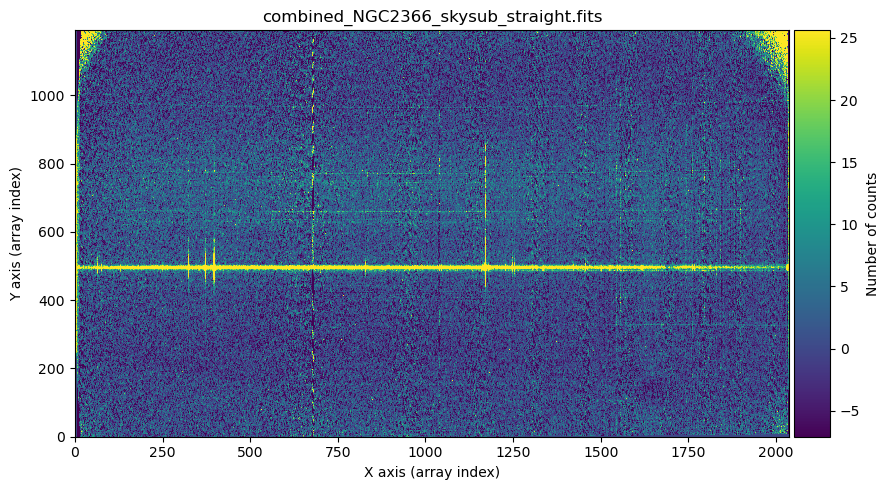

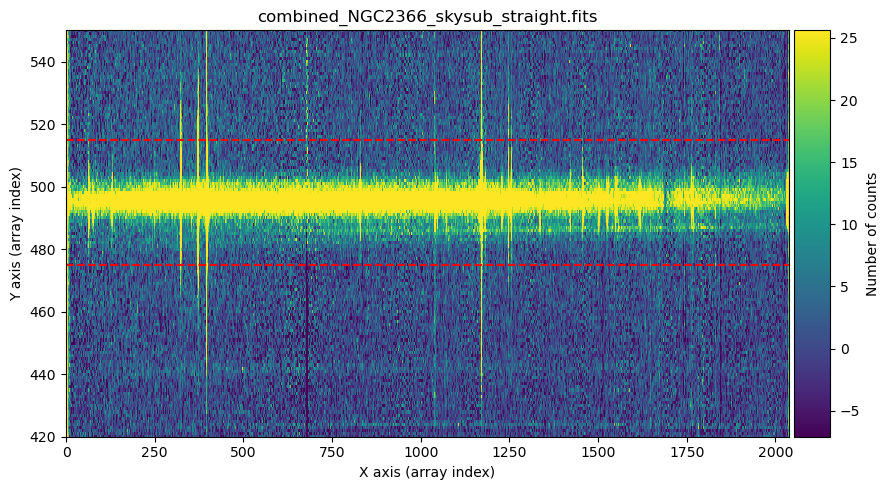

In [12]:
vmin, vmax = np.percentile(data, [5, 99])

for iplot in range(2):
    fig, ax = plt.subplots(figsize=(9, 5))
    tea.imshow(fig, ax, data, vmin=vmin, vmax=vmax, 
               title=f"{str(input_filename).split('/')[-1]}", 
               cmap='viridis', aspect='auto')
    if iplot == 1:
        ax.set_ylim(420, 550)
        ax.axhline(475, color='red', linestyle='--')
        ax.axhline(515, color='red', linestyle='--')
    plt.tight_layout()
    plt.show()

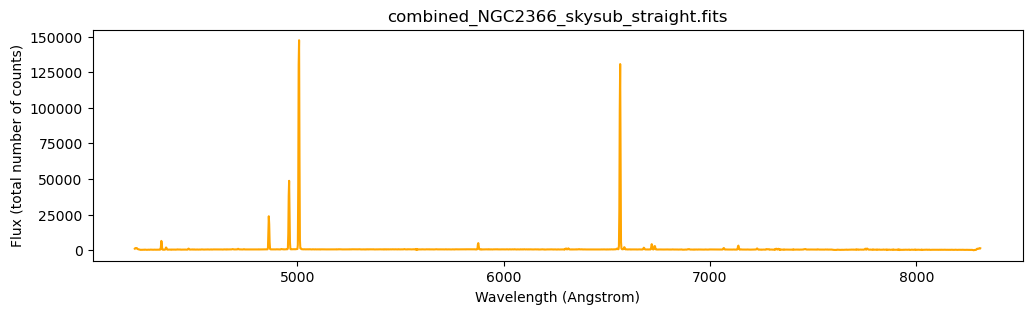

In [13]:
ns1 = 475
ns2 = 515

spectrum_1 = np.sum(data[ns1:(ns2+1), :], axis=0)

fig, ax = plt.subplots(figsize=(12, 3))

ax.plot(wavelength.to(u.Angstrom), spectrum_1, color='orange')
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Flux (total number of counts)')
ax.set_title(f"{str(input_filename).split('/')[-1]}")

plt.show()


In [14]:
## saving de 1D spectrum
table_spectrum = QTable()

table_spectrum['wavelength'] = wavelength.to(u.Angstrom)
table_spectrum['flux'] = spectrum_1 * u.adu

table_spectrum['wavelength'].info.format = '.2f'
table_spectrum['flux'].info.format = '.2f'

table_spectrum.write(dir_calibration / f'{galaxy_ID}_1d_spec.ecsv', overwrite=True)

### Spectro-photometric star

NAXIS1=2039
NAXIS2=1191


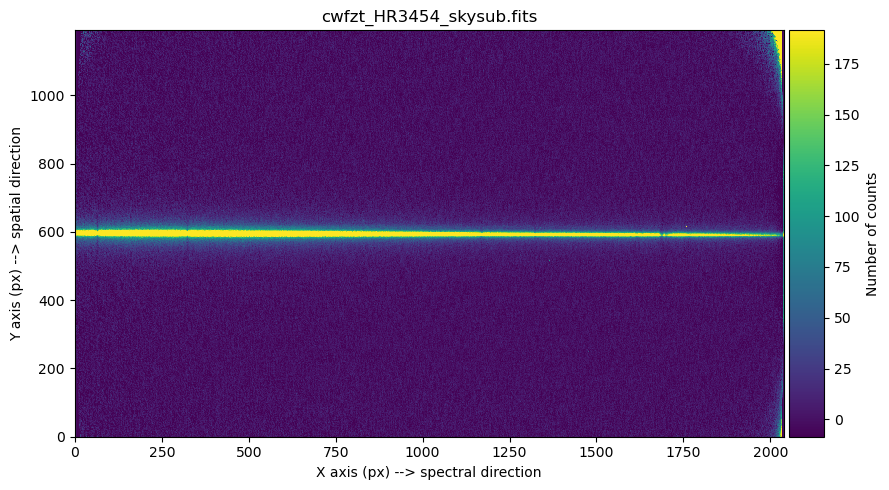

In [15]:
input_filename = dir_calibration / f'cwfzt_{specphot_star_ID}_skysub.fits'
data   = fits.getdata(input_filename)
header = fits.getheader(input_filename)

naxis2, naxis1 = data.shape
print(f'NAXIS1={naxis1}')
print(f'NAXIS2={naxis2}')

vmin, vmax = np.percentile(data, [5, 99])

fig, ax = plt.subplots(figsize=(9, 5))
tea.imshow(fig, ax, data, vmin=vmin, vmax=vmax,
           title=f"{str(input_filename).split('/')[-1]}",
           cmap='viridis', aspect='auto')

ax.set_xlabel('X axis (px) --> spectral direction')
ax.set_ylabel('Y axis (px) --> spatial direction')
plt.tight_layout()



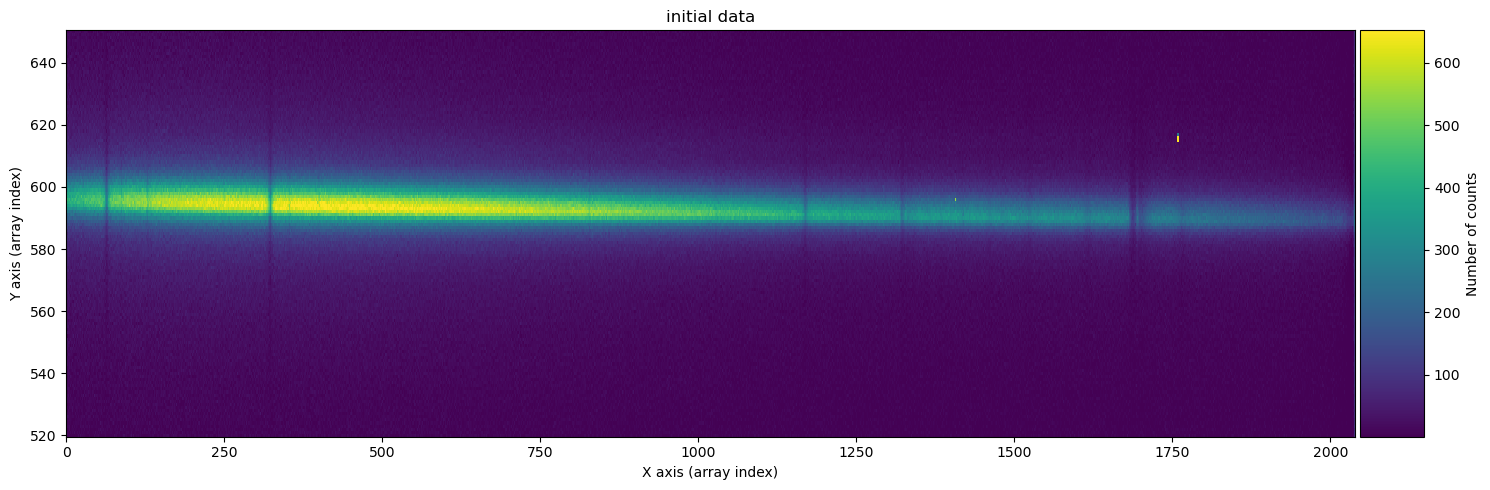

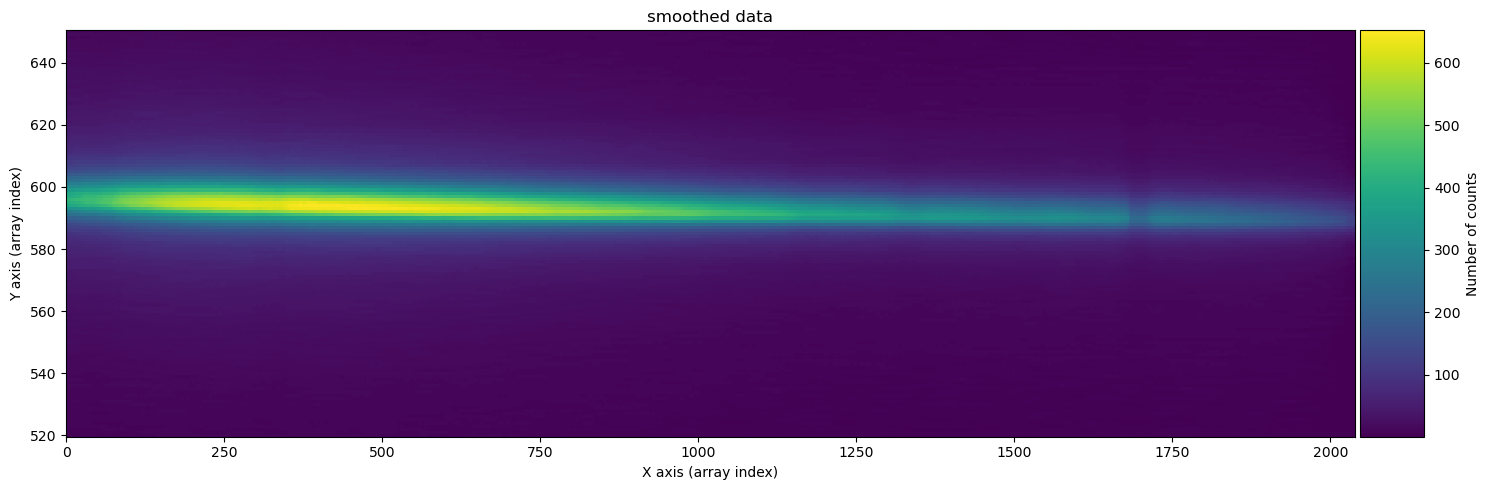

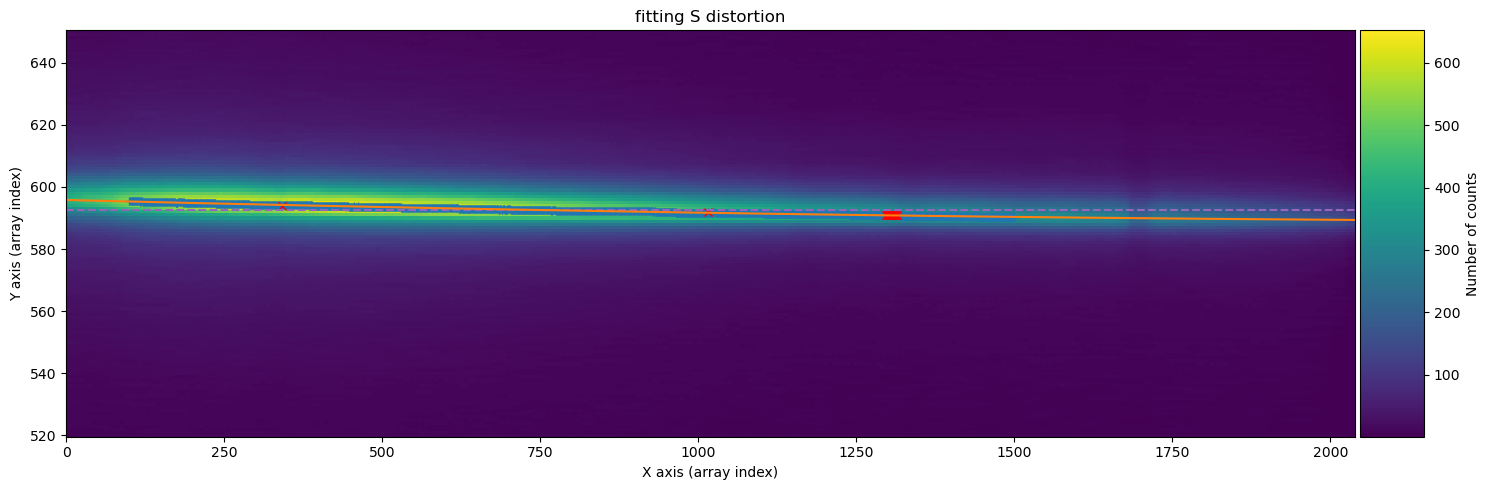

  0%|          | 0/2039 [00:00<?, ?it/s]

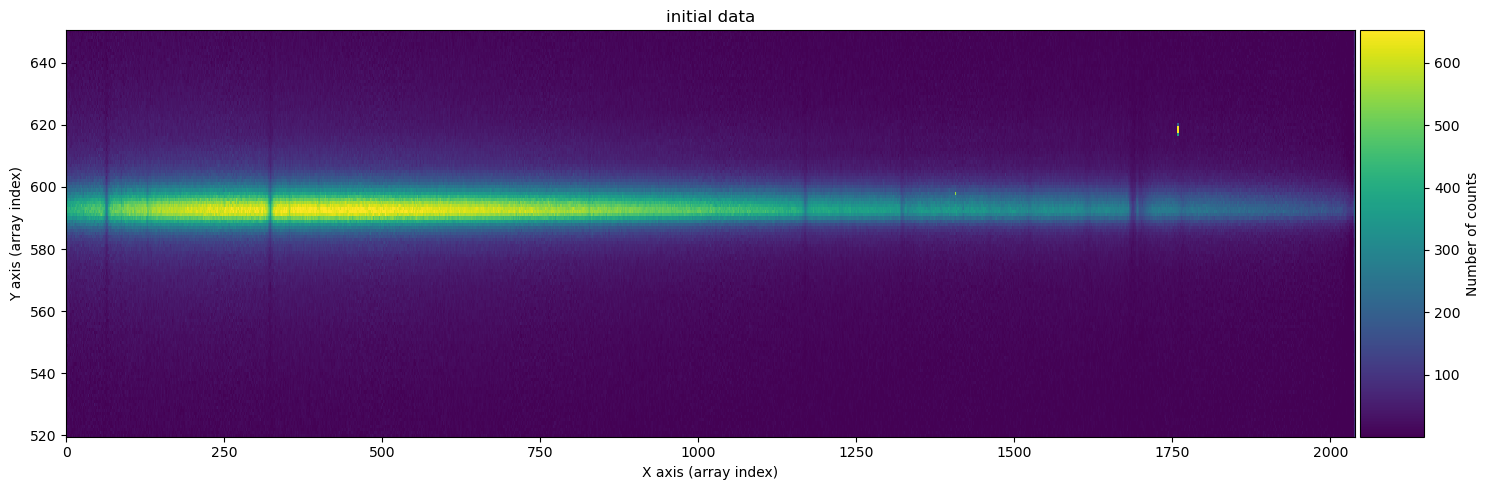

In [16]:
data_straight, poly_funct_peaks = tea.fit_sdistortion(data=data,
                                                      ns_min=520,
                                                      ns_max=650,
                                                      nc_min=100,
                                                      nc_max=1500,
                                                      median_size=(1, 51),
                                                      cmap='viridis')

In [17]:
hdu = fits.PrimaryHDU(data=data_straight, header=header)
output_filename = Path(input_filename.parent) / f'{input_filename.stem}_straight.fits'

hdu.writeto(output_filename, overwrite=True)

#### Extraction of the 1D spectrum

crpix1: 1.0 pix
crval1: 4.2130519482283e-07 m
cdelt1: 2.0102772216371e-10 m / pix
cunit1: 1.0 m
ctype1: AWAV


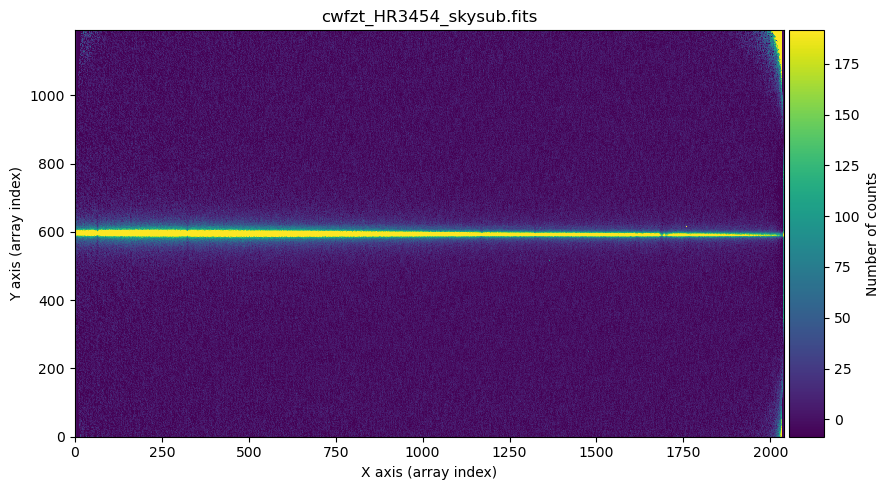

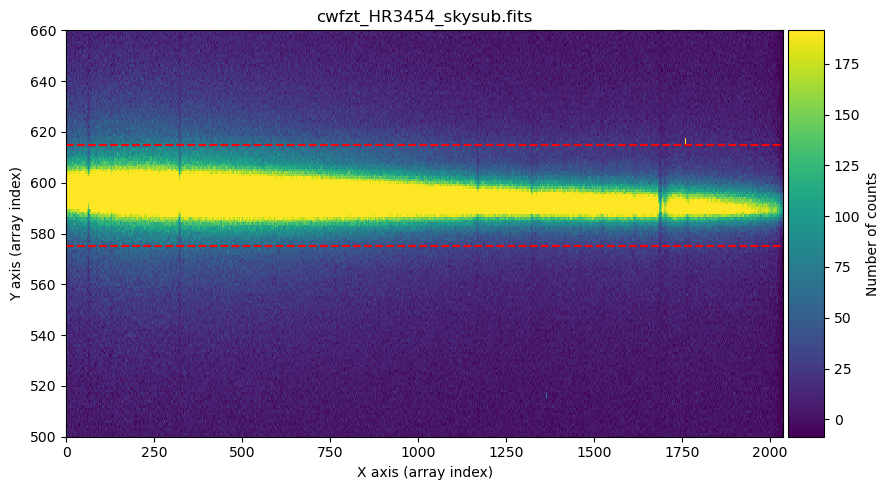

In [21]:
c = output_filename
data   = fits.getdata(dir_calibration / input_filename)
header = fits.getheader(dir_calibration / input_filename)

cunit1 = 1 * u.Unit(header['cunit1'])
crpix1 = header['crpix1'] * u.pixel
crval1 = header['crval1'] * u.Unit(cunit1)
cdelt1 = header['cdelt1'] * u.Unit(cunit1) / u.pixel
ctype1 = header['ctype1']
print(f'crpix1: {crpix1}')
print(f'crval1: {crval1}')
print(f'cdelt1: {cdelt1}')
print(f'cunit1: {cunit1}')
print(f'ctype1: {ctype1}')

wavelength = crval1 + ((np.arange(naxis1) + 1)*u.pixel - crpix1) * cdelt1

vmin, vmax = np.percentile(data, [5, 99])

for iplot in range(2):
    fig, ax = plt.subplots(figsize=(9, 5))
    tea.imshow(fig, ax, data, vmin=vmin, vmax=vmax, 
               title=f"{str(input_filename).split('/')[-1]}", 
               cmap='viridis', aspect='auto')
    if iplot == 1:
        ax.set_ylim(500, 660)
        ax.axhline(575, color='red', linestyle='--')
        ax.axhline(615, color='red', linestyle='--')
    plt.tight_layout()
    plt.show()

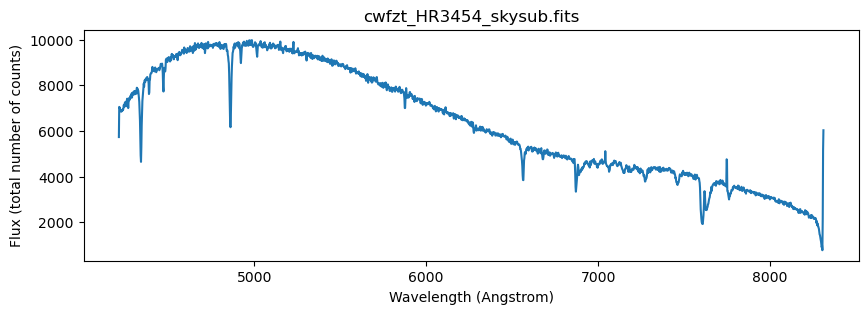

In [22]:
ns1 = 575
ns2 = 615

spectrum = np.sum(data[ns1:(ns2+1), :], axis=0)

fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(wavelength.to(u.Angstrom), spectrum)
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Flux (total number of counts)')
ax.set_title(f"{str(input_filename).split('/')[-1]}")

plt.show()

In [23]:
## saving de 1D spectrum
table_spectrum = QTable()

table_spectrum['wavelength'] = wavelength.to(u.Angstrom)
table_spectrum['flux'] = spectrum * u.adu

table_spectrum['wavelength'].info.format = '.2f'
table_spectrum['flux'].info.format = '.2f'

table_spectrum.write(dir_calibration / f'{specphot_star_ID}_1d_spec.ecsv', overwrite=True)